In [7]:
import os, shutil

base_dir = './data/intel_clf/'
train_dir = './data/intel_clf/train/seg_train/'
validation_dir = './data/intel_clf/validation/seg_pred'
test_dir = './data/intel_clf/test/seg_test/'

classes = ['buildings', 'forest', 'glacier',
          'mountain', 'sea', 'street']

for i in classes:
    print(f'Total {i} training images: {len(os.listdir(train_dir + i))}')

Total buildings training images: 2191
Total forest training images: 2271
Total glacier training images: 2404
Total mountain training images: 2512
Total sea training images: 2274
Total street training images: 2382


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=72,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=72,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


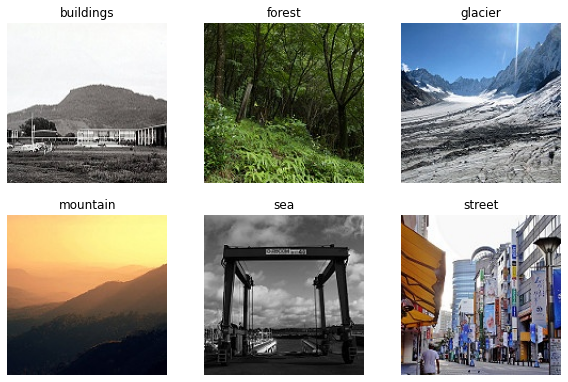

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

fnames = []

for i in os.listdir(train_dir):
    fname = os.listdir(os.path.join(train_dir, i))[0]
    fnames.append((i, os.path.join(train_dir, i, fname)))

plt.figure(figsize=(10, 10))
i = 0
for lables, images in fnames:
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(images)
    plt.imshow(img[...,::-1])
    plt.title(lables)
    plt.axis("off")
    i += 1

In [10]:
import tensorflow as tf

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=20)

Epoch 1/30
100/100 [==============================] - 69s 691ms/step - loss: 1.4240 - accuracy: 0.3817 - val_loss: 1.2530 - val_accuracy: 0.4764
Epoch 2/30
100/100 [==============================] - 68s 674ms/step - loss: 1.2167 - accuracy: 0.4907 - val_loss: 1.0671 - val_accuracy: 0.5750
Epoch 3/30
100/100 [==============================] - 63s 625ms/step - loss: 1.1455 - accuracy: 0.5333 - val_loss: 0.9902 - val_accuracy: 0.5958
Epoch 4/30
100/100 [==============================] - 63s 634ms/step - loss: 1.0695 - accuracy: 0.5736 - val_loss: 0.9247 - val_accuracy: 0.6451
Epoch 5/30
100/100 [==============================] - 64s 638ms/step - loss: 0.9994 - accuracy: 0.6154 - val_loss: 0.9614 - val_accuracy: 0.6361
Epoch 6/30
100/100 [==============================] - 65s 652ms/step - loss: 0.9401 - accuracy: 0.6394 - val_loss: 0.8740 - val_accuracy: 0.6917
Epoch 7/30
100/100 [==============================] - 68s 681ms/step - loss: 0.9536 - accuracy: 0.6383 - val_loss: 0.8019 - val_ac

In [42]:
def plot_metrics(history):
    hist_dict = history.history
    
    acc = hist_dict['accuracy']
    val_acc = hist_dict['val_accuracy']
    loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()
    

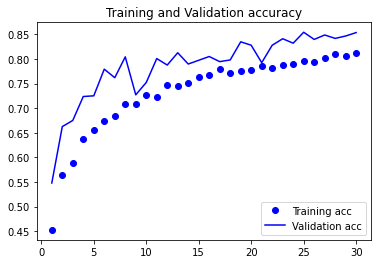

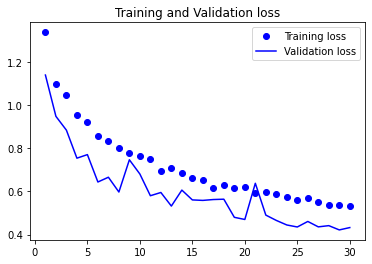

In [43]:
plot_metrics(history)

In [13]:
model.save('intel_clf.h5')

In [14]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                    include_top=False,
                    input_shape=(150, 150, 3))

In [15]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [16]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['accuracy'])

history = model.fit(train_generator,
                   steps_per_epoch=100,
                   epochs=10,
                   validation_data=validation_generator,
                   validation_steps=20)

Epoch 1/10
100/100 [==============================] - 56s 553ms/step - loss: 0.5714 - accuracy: 0.7985 - val_loss: 0.4885 - val_accuracy: 0.8257
Epoch 2/10
100/100 [==============================] - 55s 544ms/step - loss: 0.5415 - accuracy: 0.7993 - val_loss: 0.4890 - val_accuracy: 0.8285
Epoch 3/10
100/100 [==============================] - 51s 511ms/step - loss: 0.5420 - accuracy: 0.8001 - val_loss: 0.4550 - val_accuracy: 0.8326
Epoch 4/10
100/100 [==============================] - 51s 512ms/step - loss: 0.5347 - accuracy: 0.8046 - val_loss: 0.4681 - val_accuracy: 0.8306
Epoch 5/10
100/100 [==============================] - 51s 510ms/step - loss: 0.5300 - accuracy: 0.8018 - val_loss: 0.4856 - val_accuracy: 0.8299
Epoch 6/10
100/100 [==============================] - 52s 523ms/step - loss: 0.5323 - accuracy: 0.8053 - val_loss: 0.5175 - val_accuracy: 0.8264
Epoch 7/10
100/100 [==============================] - 51s 511ms/step - loss: 0.5285 - accuracy: 0.8031 - val_loss: 0.4655 - val_ac

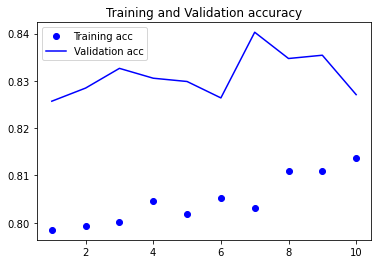

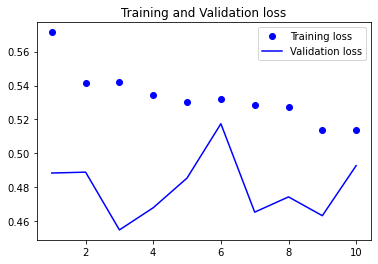

In [18]:
plot_metrics(history)

In [19]:
def smooth_curve(points, factor=.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

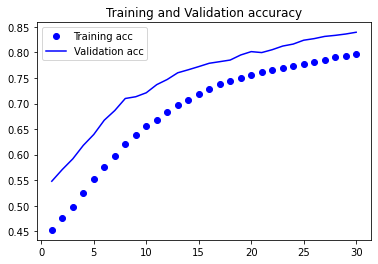

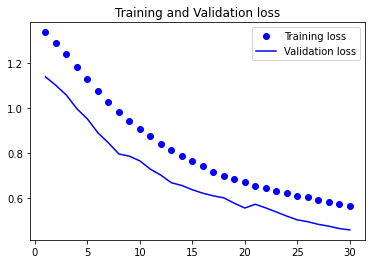

In [44]:
hist_dict = history.history
    
acc = smooth_curve(hist_dict['accuracy'])
val_acc = smooth_curve(hist_dict['val_accuracy'])
loss = smooth_curve(hist_dict['loss'])
val_loss = smooth_curve(hist_dict['val_loss'])

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


In [27]:
import pandas as pd


d = {'file_path' : [], 'labels' : []}

for i in os.listdir(train_dir):
    for j in os.listdir(os.path.join(train_dir, i)):
        d['file_path'].append(os.path.join(i,j))
        d['labels'].append(i)

df = pd.DataFrame(d)
df

,file_path,labels
0,mountain/19468.jpg,mountain
1,mountain/6914.jpg,mountain
2,mountain/12907.jpg,mountain
3,mountain/16503.jpg,mountain
4,mountain/17588.jpg,mountain
...,...,...
14029,glacier/9260.jpg,glacier
14030,glacier/10820.jpg,glacier
14031,glacier/9079.jpg,glacier
14032,glacier/9109.jpg,glacier


In [32]:
def create_model(train_gen, val_gen):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(6, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics='accuracy')

    history = model.fit(train_gen,
                       steps_per_epoch=100,
                       epochs=5,
                       validation_data=val_gen,
                       validation_steps=20,
                       verbose=0)
    return history

In [33]:
from sklearn.model_selection import KFold

df = df.sample(frac=1)

acc = []
val_acc = []

kf = KFold(n_splits=10)
i = 0
for train_idx, val_idx in kf.split(np.zeros(df.shape[0]), df['labels']):
    
    print(f'KFold split {i}')
    i += 1
    
    training_data = df.iloc[train_idx]
    validation_data = df.iloc[val_idx]
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        training_data,
        train_dir,
        x_col='file_path',
        y_col='labels',
        target_size=(150,150),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )
    
    validation_generator = test_datagen.flow_from_dataframe(
        validation_data,
        train_dir,
        x_col='file_path',
        y_col='labels',
        target_size=(150,150),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )
    
    
    hist = create_model(train_generator, validation_generator)
    
    acc.append(hist.history['accuracy'])
    val_acc.append(hist.history['val_accuracy'])
    
# print(acc, val_acc)

KFold split 0
Found 12630 validated image filenames belonging to 6 classes.
Found 1404 validated image filenames belonging to 6 classes.
KFold split 1
Found 12630 validated image filenames belonging to 6 classes.
Found 1404 validated image filenames belonging to 6 classes.
KFold split 2
Found 12630 validated image filenames belonging to 6 classes.
Found 1404 validated image filenames belonging to 6 classes.
KFold split 3
Found 12630 validated image filenames belonging to 6 classes.
Found 1404 validated image filenames belonging to 6 classes.
KFold split 4
Found 12631 validated image filenames belonging to 6 classes.
Found 1403 validated image filenames belonging to 6 classes.
KFold split 5
Found 12631 validated image filenames belonging to 6 classes.
Found 1403 validated image filenames belonging to 6 classes.
KFold split 6
Found 12631 validated image filenames belonging to 6 classes.
Found 1403 validated image filenames belonging to 6 classes.
KFold split 7
Found 12631 validated image

In [37]:
test_datgen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    shuffle=True
)

test_steps_per_epoch = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 7s 74ms/step
[2 0 5 ... 0 1 2]


In [38]:
from sklearn import metrics

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
cf_matrix=confusion_matrix(true_classes, predicted_classes)
print(cf_matrix)

[[ 78  72  68  85  56  78]
 [ 72  76  74  89  73  90]
 [ 89  85 103  95  81 100]
 [ 84  71  83 110  84  93]
 [ 73  88  95 101  73  80]
 [ 72  88  72  98  70 101]]
